In [1]:
import cv2
import numpy as np

## Setting up camera

In [2]:
# def nothing(x):
#     pass

# cv2.namedWindow("Window")
# cv2.createTrackbar("Param Name", "Window", 0, 10, nothing)

In [3]:
def try_camera(func):
    cap = cv2.VideoCapture(0)

    while(True):
        # Capture frame-by-frame
        ret, frame = cap.read()

        # Our operations on the frame come here
        try:
            gray = func(frame) # cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

            # Display the resulting frame
            cv2.imshow('frame', gray)
        except:
            print("Nothing found...")
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # When everything done, release the capture
    cap.release()
    cv2.destroyAllWindows()
    
# try_camera(lambda x : x)

## Part 1: Extracting Hand from Feed

In [4]:
# ! {"pip install matplotlib"}

In [5]:
frame = np.load('open_palm.npy')

In [6]:
import matplotlib.pyplot as plt

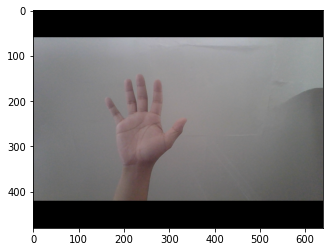

In [7]:
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [8]:
frame.shape

(480, 640, 3)

In [9]:
def get_skinmask(frame):
    lower_HSV = np.array([0, 70, 0], dtype = "uint8")  
    upper_HSV = np.array([25, 255, 255], dtype = "uint8")  

    convertedHSV = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)  
    skinMaskHSV = cv2.inRange(convertedHSV, lower_HSV, upper_HSV)  


    lower_YCrCb = np.array((0, 138, 67), dtype = "uint8")  
    upper_YCrCb = np.array((255, 173, 133), dtype = "uint8")  

    convertedYCrCb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)  
    skinMaskYCrCb = cv2.inRange(convertedYCrCb, lower_YCrCb, upper_YCrCb)  

    skinMask = cv2.add(skinMaskHSV,skinMaskYCrCb)  
    return skinMask

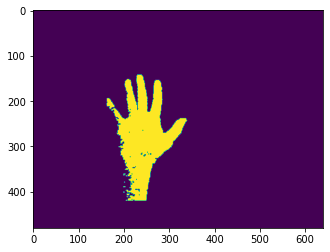

In [10]:
plt.imshow(get_skinmask(frame))

Testing Code

In [11]:
try_camera(get_skinmask)

In [12]:
def morph_and_blur(frame, skinMask):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2, 2))  
    skinMask = cv2.erode(skinMask, kernel, iterations = 1)  
    skinMask = cv2.dilate(skinMask, kernel, iterations = 1)  

    # blur the mask to help remove noise, then apply the  
    # mask to the frame  
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0) 
    skin = cv2.bitwise_and(frame, frame, mask = skinMask) 
    return skin

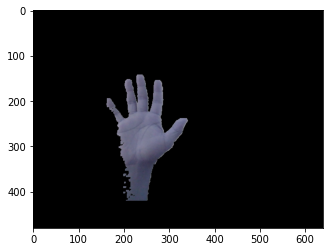

In [13]:
plt.imshow(morph_and_blur(frame, get_skinmask(frame)))

In [14]:
isolate = lambda x : morph_and_blur(x, get_skinmask(x))
try_camera(isolate)

## Part 2: Connected Components for Gesture Recognition

In [15]:
ok_hand = np.load('ok.npy')

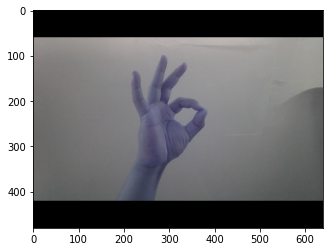

In [16]:
plt.imshow(ok_hand)

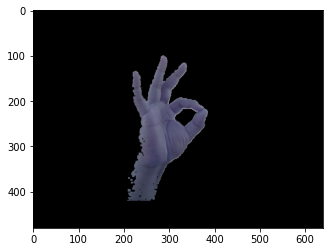

In [17]:
plt.imshow(isolate(ok_hand).astype(np.uint8))

In [18]:
def gray_thresh(frame):
    max_binary_value = 10
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)  
    ret, thresh = cv2.threshold(gray, 0, max_binary_value, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU )
    return thresh # thresh if ret else None

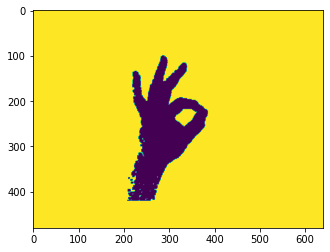

In [19]:
plt.imshow(gray_thresh(isolate(ok_hand)))

In [20]:
def arr2img(arr):
    arr = np.uint8(arr / np.max(arr) * 255)
    return cv2.merge([arr, arr, arr])

In [21]:
# try_camera(lambda x : arr2img(gray_thresh(isolate(x))))

In [22]:
def get_connect(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    return arr2img(markers)

In [23]:
marks = get_connect(gray_thresh(isolate(ok_hand)))

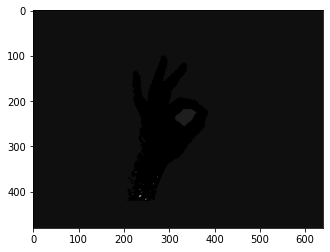

In [24]:
plt.imshow(marks)

Test out code so far...

In [25]:
render_comps = lambda x : get_connect(gray_thresh(isolate(x)))
# try_camera(render_comps)

In [26]:
def get_connect2(img):
    ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
    markers = np.array(markers, dtype=np.uint8)  
    labeled_img = arr2img(markers)
    
    # sort by area of ROI
    statsSortedByArea = stats[np.argsort(stats[:, 4])]  
    roi = statsSortedByArea[-3][0:4]  
    x, y, w, h = roi  
    subImg = labeled_img[y:y+h, x:x+w]
    subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)
    
    _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
    maxCntLength = 0  
    for i in range(0,len(contours)):  
        cntLength = len(contours[i])  
        if(cntLength>maxCntLength):  
            cnt = contours[i]  
            maxCntLength = cntLength  
    if(maxCntLength>=5):  
        ellipseParam = cv2.fitEllipse(cnt)
        (x,y), (MA, ma), angle = ellipseParam
        print(f"(x={x}, y={y}), (MA={MA}, ma={ma}), Angle={angle}")
        subImg = cv2.cvtColor(subImg, cv2.COLOR_GRAY2RGB);  
        subImg = cv2.ellipse(subImg,ellipseParam,(0,255,0),2)  

    subImg = cv2.resize(subImg, (0,0), fx=3, fy=3)
    return subImg

In [27]:
render_comps2 = lambda x : get_connect2(gray_thresh(isolate(x)))
try_camera(render_comps2)

Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
Nothing found...
(x=2.134519100189209, y=3.4154343605041504), (MA=2.8291728496551514, ma=8.567451477050781), Angle=35.73862838745117
(x=39.52916717529297, y=44.576942443847656), (MA=50.761138916015625, ma=86.82855224609375), Angle=46.537452697753906
(x=36.02812194824219, y=34.56342697143555), (MA=43.54663848876953, ma=82.89584350585938), Angle=51.439697265625
(x=34.086

## Part 3: Tracking 2D Finger Positions

In [28]:
def get_gray_thresh(x):
    img = arr2img(1 * (gray_thresh(isolate(x)) == 0))
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

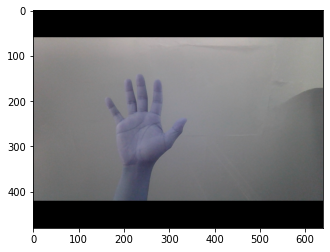

In [29]:
plt.imshow(np.load('open_palm.npy'))

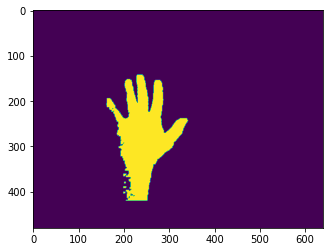

In [30]:
plt.imshow(get_gray_thresh(np.load('open_palm.npy')))

In [31]:
def get_hull(thresholdedHandImage):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    thresholdedHandImage = cv2.cvtColor(thresholdedHandImage, cv2.COLOR_GRAY2BGR)
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append(far)
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                
        print(fingerCount)
        
    return thresholdedHandImage

In [32]:
get_conv_img = lambda x : get_hull(get_gray_thresh(x))

3


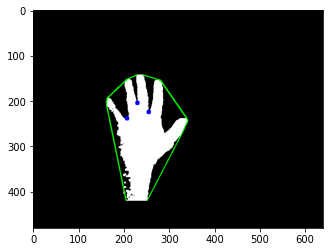

In [33]:
plt.imshow(get_conv_img(np.load('open_palm.npy')))

In [34]:
try_camera(get_conv_img)

c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


1
1
2
4
2
5
5
3
3
3
3
3
3
3
3
3
1
3
3
2


c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: overflow encountered in int_scalars
c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt
c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in arccos


2
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
2
3
2
2
2
2
2
2
2
2
2
2
3
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
1
2
2
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
4
3
3
3
4
3
3
3
3
3
3
3
3
1
1
1
1
1
1
1
1
1
1
2
1
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3


## Part 4: Control Mouse and Keyboard

Simple Gestures:
1. Finger Count:
    - 2 = open file
    - 3 = save file
    
2. Pinch - Draw/Click

Complex Gestures:
    
Implemented:

5. Closed + Center Circle Radius > 120 == Ctrl + Z

6. Pinch Axis Angle - Rotation

7. 

Harder:

3. Open - Close
    - Zoom Out
    
4. Close - Open
    - Zoom In
    
Thinking:

7. Close + Move + Open == Change Hue

In [35]:
from scipy.stats import mode

In [110]:
def paint_conv_on_frame(thresholdedHandImage, regular_img, centers, open_closes, finger_counts):
    _, contours, _ = cv2.findContours(thresholdedHandImage, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText  = (10,30)
    bottomLeftCornerOfText2 = (10,60)
    fontScale              = 1
    fontColor              = (255,255,255)
    lineType               = 2
    
    thresholdedHandImage = regular_img
    contours = sorted(contours,key=cv2.contourArea,reverse=True)
    fingerCount = 0
    fingerPts = []
    startEndPts = []
    if len(contours)>1:  
        largestContour = contours[0]  
        hull = cv2.convexHull(largestContour, returnPoints = False)     
        for cnt in contours[:1]:  
            defects = cv2.convexityDefects(cnt,hull)  
            if(not isinstance(defects,type(None))):  
                for i in range(defects.shape[0]):  
                    s,e,f,d = defects[i,0]  
                    start = tuple(cnt[s][0])  
                    end = tuple(cnt[e][0])  
                    far = tuple(cnt[f][0])
                    
                    # finger detection
                    c_squared = (end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2  
                    a_squared = (far[0] - start[0]) ** 2 + (far[1] - start[1]) ** 2  
                    b_squared = (end[0] - far[0]) ** 2 + (end[1] - far[1]) ** 2  
                    angle = np.arccos((a_squared + b_squared  - c_squared ) / (2 * np.sqrt(a_squared * b_squared ))) 
                    
                    if angle <= np.pi / 3:
                        fingerCount += 1 
                        cv2.circle(thresholdedHandImage,far,5,[0,0,255],-1)
                        fingerPts.append([far[i] for i in range(len(far))])
                    
                    cv2.line(thresholdedHandImage,start,end,[0,255,0],2)
                    # cv2.circle(thresholdedHandImage,start,5,[i * 20,0,255],-1)
                    # cv2.circle(thresholdedHandImage,end,5,[i * 20 + 100,0,255],-1)
                    startEndPts.append([start[i] for i in range(len(start))])
                    # startEndPts.append([end[i] for i in range(len(end))])
                    
                    
        # Hand Tracking
        if len(startEndPts) > 5:
            M = cv2.moments(largestContour)  
            cX = 0 + 1 * int(M["m10"] / M["m00"])  
            cY = 0 + int(0.9 * M["m01"] / M["m00"])
            centers.append(np.array([cX, cY]))
            centers_mat = np.vstack(centers)
            center = np.mean(centers_mat, axis=0).astype(np.int)

            font                   = cv2.FONT_HERSHEY_SIMPLEX
            bottomLeftCornerOfText = (10,30)
            fontScale              = 1
            fontColor              = (255,255,255)
            lineType               = 2
            cv2.circle(thresholdedHandImage, (center[0], center[1]), 5, [0,255,255], -1)
        
        # Draw Circle from Moment Center
        if len(startEndPts) > 5:
            pts = np.array(startEndPts)
            min_pts = np.array([cX, np.amin(pts, axis=0)[1]])
            dist = np.linalg.norm(min_pts - center, 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 60, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), 120, [0,255,255], 2)
            thresholdedHandImage = cv2.circle(
                thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)
        
        # Open Palm Detection
        if len(fingerPts) > 0 and len(startEndPts) > 5:
            pts = np.array(fingerPts)
            mean_pts = np.mean(pts, axis=0)
            min_pts = np.amin(pts, axis=0)
            dist = np.linalg.norm(min_pts - center, 2)
            # thresholdedHandImage = cv2.circle(
            #     thresholdedHandImage, (center[0], center[1]), int(dist), [0,255,0], 2)

            # print(tuple(np.ceil(mean_pts).astype(int).tolist()))
            open_closes.append(1)
            finger_counts.append(len(fingerPts))
            mean_finger_count = int(np.mean(finger_counts))
            cv2.putText(thresholdedHandImage, f"Num Fingers: {mean_finger_count}", 
                        bottomLeftCornerOfText2, 
                        font, fontScale, fontColor, lineType)
        elif len(startEndPts) > 5:
            open_closes.append(0)
        else:
            open_closes.append(-1)
    else:
        open_closes.append(-1)
        
    if np.mean(open_closes) >= 0.33:
        cv2.putText(thresholdedHandImage, "Open", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    elif np.mean(open_closes) < 0.33 and np.mean(open_closes) >= -0.33:
        cv2.putText(thresholdedHandImage, "Closed", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    else:
        cv2.putText(thresholdedHandImage, "No Hand Detected", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
            
    return thresholdedHandImage, centers, open_closes

def draw_center_of_ellipse(img, disp, center, pinches, angles, diff_angles):
    img = gray_thresh(isolate(img))
    try:
        ret, markers, stats, centroids = cv2.connectedComponentsWithStats(img, ltype=cv2.CV_16U)  
        markers = np.array(markers, dtype=np.uint8)  
        labeled_img = arr2img(markers)

        # sort by area of ROI
        statsSortedByArea = stats[np.argsort(stats[:, 4])]  
        roi = statsSortedByArea[-3][0:4]  
        x, y, w, h = roi
        
        subImg = labeled_img[y:y+h, x:x+w]
        subImg = cv2.cvtColor(subImg, cv2.COLOR_BGR2GRAY)

        _, contours, _ = cv2.findContours(subImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)  
        maxCntLength = 0  
        for i in range(0,len(contours)):  
            cntLength = len(contours[i])  
            if(cntLength>maxCntLength):  
                cnt = contours[i]  
                maxCntLength = cntLength  
        if(maxCntLength>=5):  
            ellipseParam = cv2.fitEllipse(cnt)
            (x_sub, y_sub), (MA, ma), angle = ellipseParam
            
            # Checking Location
            check_center1 = x > center[0]
            check_center2 = x + w > center[0]
            check_center3 = y < center[1]
            check_center4 = y + h < center[1]
            print(w * h)
            
            check_center = check_center2 and (check_center3 or check_center4)
            
            if check_center and (w * h > 1300 and w * h < 3000):
                # Draw Ellipse Location
                cv2.circle(disp, (x, y), 5, [100 if check_center1 else 255, 10, 0], 2)
                cv2.line(disp, (x, y), (x + w, y),[100, 10, 0],2)
                
                cv2.circle(disp, (x + w, y), 5, [100 if check_center2 else 255, 10, 0], 2)
                cv2.line(disp, (x + w, y), (x + w, y + h),[100, 10, 0],2)
                
                cv2.circle(disp, (x + h, y + h), 5, [100 if check_center3 else 255, 10, 0], 2)
                cv2.line(disp, (x + w, y + h), (x, y + h),[100, 10, 0],2)
                
                cv2.circle(disp, (x, y + h), 5, [100 if check_center4 else 255, 10, 0], 2)
                cv2.line(disp, (x, y + h), (x, y),[100, 10, 0],2)

                print(w * h, angle)
                pinches.append(1)
                if np.mean(pinches) > 0.8:
                    angles.append(int(angle))
                    diff_angles.append(int(angles[-1] - angles[0]))
                    return np.mean(pinches) > 0.8
                else:
                    angles.append(int(angles[-1]))
                    diff_angles.append(int(angles[-1] - angles[0]))
                    return False
            
        angles.append(int(angles[-1]))
        diff_angles.append(int(angles[-1] - angles[0]))
        pinches.append(0)
        return False
    except:
        angles.append(int(angles[-1]))
        diff_angles.append(int(angles[-1] - angles[0]))
        pinches.append(0)
        return False

In [ ]:
cap = cv2.VideoCapture(0)
centers_arr = []
open_closes_arr = [-1]
finger_counts = []
pinches = []
angles = [0]
diff_angles = [0, 0]
curr_angle = 0
mean_angles = [0] * 15

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    # Our operations on the frame come here
    # try:
    gray = get_gray_thresh(frame)
    disp, centers_arr, open_closes_arr = paint_conv_on_frame(
        gray, frame, centers_arr, open_closes_arr, finger_counts
    )
    
    if len(centers_arr) > 1:
        centers_mat = np.vstack(centers_arr)
        ellipse_found = draw_center_of_ellipse(
            frame, disp, np.mean(centers_mat, axis=0).astype(np.int), 
            pinches, angles, diff_angles
        )
    
    if ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText  = (10, 90 + 60)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, f"Pinch. ({np.mean(angles)}, {np.mean(diff_angles)}).", 
                        bottomLeftCornerOfText, 
                        font, fontScale, fontColor, lineType)
    
    if angles and mean_angles[-1] - mean_angles[0] > 30 and ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText3= (10, 200 + 60)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, "rotate ccw", 
                        bottomLeftCornerOfText3, 
                        font, fontScale, fontColor, lineType)
        curr_angle += 5
        
    if angles and mean_angles[-1] - mean_angles[0] < -30 and ellipse_found:
        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText4= (10, 150 + 60)
        fontScale              = 1
        fontColor              = (255,255,255)
        lineType               = 2
        cv2.putText(disp, "rotate cw", 
                        bottomLeftCornerOfText4, 
                        font, fontScale, fontColor, lineType)
        curr_angle -= 5
        
    font                    = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText  = (10,90)
    fontScale               = 1
    fontColor               = (255,255,255)
    lineType                = 2
    cv2.putText(disp, f"Curr Angle: {int(np.mean(angles))}", 
                    bottomLeftCornerOfText, 
                    font, fontScale, fontColor, lineType)
    mean_angles.append(int(np.mean(angles)))
        
    if len(centers_arr) > 20:
        centers_arr = centers_arr[1:]
    if len(open_closes_arr) > 15:
        open_closes_arr = open_closes_arr[1:]
    if len(finger_counts) > 15:
        finger_counts = finger_counts[1:]
    if len(pinches) > 15:
        pinches = pinches[1:]
    if len(angles) > 15:
        angles = angles[1:]
    if len(diff_angles) > 15:
        diff_angles = diff_angles[1:]
    if len(mean_angles) > 15:
        mean_angles = mean_angles[1:]
        
    # Display the resulting frame
    cv2.imshow('frame', disp)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

c:\users\fcrey\anaconda3\envs\hw4env\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


3240
2912
2912 39.29347229003906
2496
2496 47.74578857421875
2805
2805 43.48439025878906
2548
2548 50.927852630615234
2491
2491 50.60823059082031
2666
2666 67.58859252929688
2288
2288 57.106346130371094
2132
2132 64.40725708007812
3072
2268
2268 62.04594039916992
2255
2255 64.66326141357422
2255
2255 64.70541381835938
2337
2337 68.40280151367188
2280
2280 70.0656967163086
2262
2262 71.96924591064453
2204
2204 74.79196166992188
2146
2146 74.39191436767578
2394
2394 66.72282409667969
2664
2664 79.53451538085938
2698
2698 80.08417510986328
2220
2220 76.29393005371094
2700
2700 68.44660186767578
2478
2478 73.1021957397461
2301
2301 76.1588363647461
2280
2280 72.57957458496094
2940
2940 72.63811492919922
2698
2698 84.99290466308594
2668
2668 81.36900329589844
3312
3312
2242
2242 75.94043731689453
2146
2146 74.380615234375
2280
2280 74.4133071899414
2146
2146 76.83293914794922
2166
2166 73.91285705566406
2072
2072 76.00263977050781
2072
2072 75.02735137939453
2072
2072 74.7430648803711
1980
